In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import itertools
import time

import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm


from tensorflow.keras import backend as K
import gc

In [12]:

labels = ['Adenocarcinoma', 'Large_cell_carcinoma', 'Normal', 'Squamous_cell_carcinoma']

from google.colab import drive
import zipfile, os

drive.mount('/content/drive')


zip_path = '/content/drive/MyDrive/Project/dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

data_path = '/content/dataset'

import cv2
import numpy as np
from tqdm import tqdm

image_size = 224

def find_label_from_folder(folder_name, labels):
    if folder_name in labels:
        return folder_name
    raise ValueError(f"Cannot find label for folder {folder_name}")

def load_images(data_path, split_names=["train", "test", "valid"], labels=None, image_size=224):
    X = []
    y = []
    if labels is None:
        raise ValueError("You must provide the list of labels explicitly.")
    for split in split_names:
        split_path = os.path.join(data_path, split)
        if not os.path.exists(split_path):
            continue
        for folder_name in os.listdir(split_path):
            folder_path = os.path.join(split_path, folder_name)
            if not os.path.isdir(folder_path):
                continue
            try:
                label = find_label_from_folder(folder_name, labels)
            except ValueError as e:
                print(e)
                continue
            for img_name in tqdm(os.listdir(folder_path), desc=f"{split}/{folder_name}"):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = load_images(data_path, labels=labels, image_size=image_size)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


valid/Normal: 100%|██████████| 13/13 [00:00<00:00, 89.52it/s]


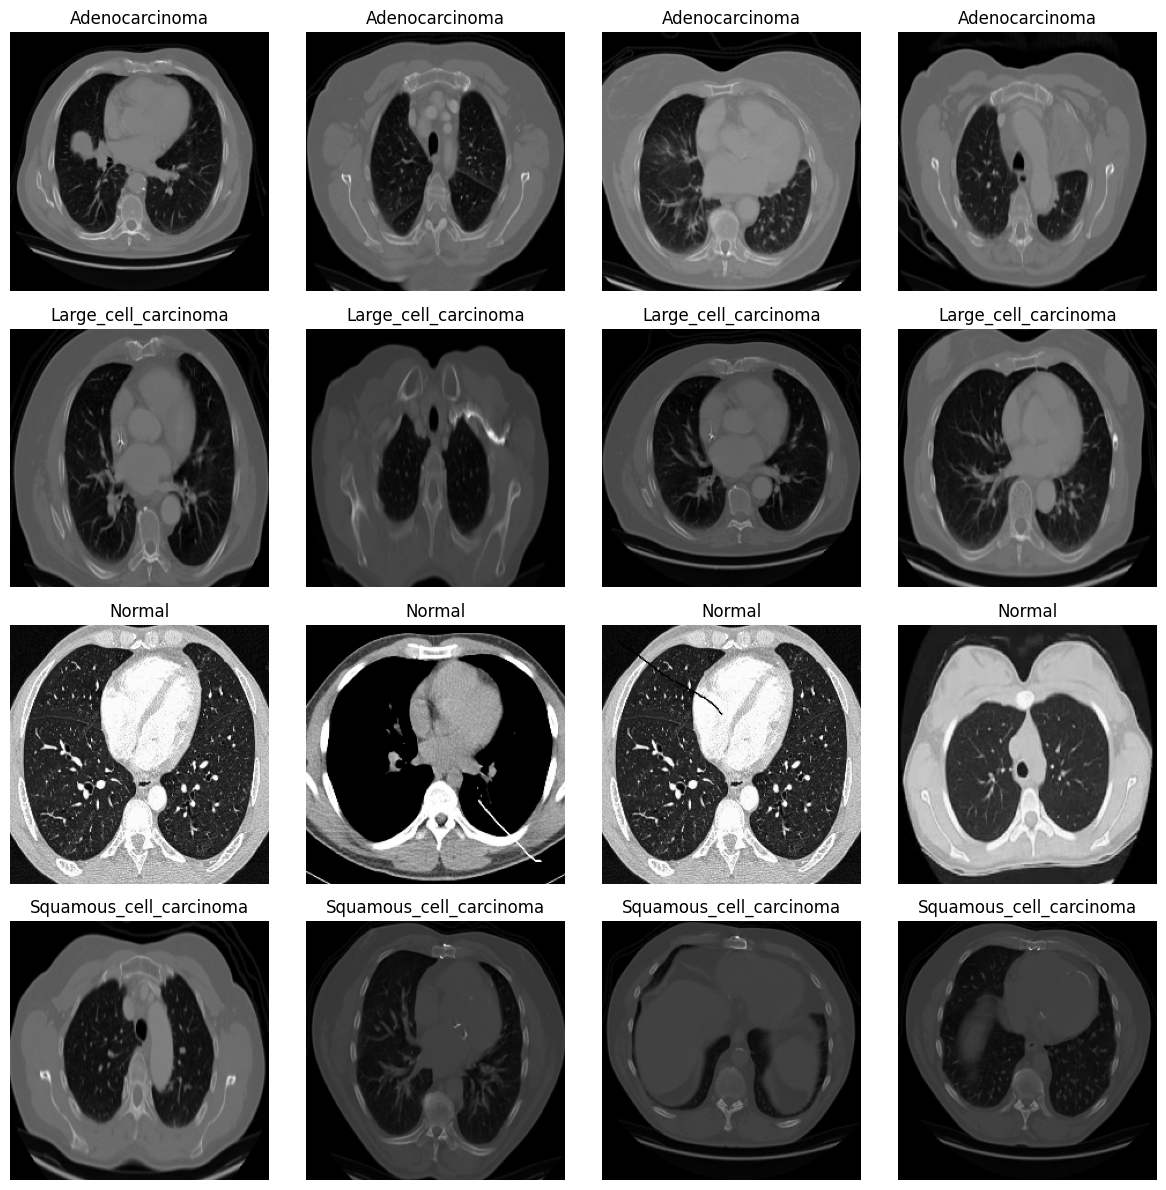

In [13]:

fig, axes = plt.subplots(len(labels), 4, figsize=(12, len(labels) * 3))

for i, label in enumerate(labels):
    indices = np.where(y == label)[0]
    random_indices = np.random.choice(indices, size=min(4, len(indices)), replace=False)

    for j, idx in enumerate(random_indices):
        ax = axes[i, j]
        ax.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
        ax.set_title(label)
        ax.axis("off")


plt.tight_layout()
plt.show()

In [14]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X,y, random_state=1)

print(f"Data shape : {X.shape}")

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.1,random_state=101)

print(f"Training data shape : {X_train.shape}")
print(f"Test data shape : {X_test.shape}")

Data shape : (1000, 224, 224, 3)
Training data shape : (900, 224, 224, 3)
Test data shape : (100, 224, 224, 3)


In [15]:
del X
del y

y_train = tf.keras.utils.to_categorical([labels.index(i) for i in y_train])
y_test = tf.keras.utils.to_categorical([labels.index(i) for i in y_test])

Epoch 1/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.6181 - loss: 1.0305 - val_accuracy: 0.7222 - val_loss: 0.7151
Epoch 2/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.9675 - loss: 0.1385 - val_accuracy: 0.7778 - val_loss: 0.5305
Epoch 3/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.9870 - loss: 0.0580 - val_accuracy: 0.8778 - val_loss: 0.5059
Epoch 4/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.9859 - loss: 0.0508 - val_accuracy: 0.8889 - val_loss: 0.5398
Epoch 5/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.9972 - loss: 0.0242 - val_accuracy: 0.8444 - val_loss: 0.6677
Epoch 6/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.9967 - loss: 0.0241 - val_accuracy: 0.8667 - val_loss: 0.6663
Epoch 7/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.9888 - loss: 0.0335 - val_accuracy: 0.8444 - val_loss: 0.7853
Epoch 8/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.9974 - loss: 0.0136 - val_accuracy: 0.8889 - v

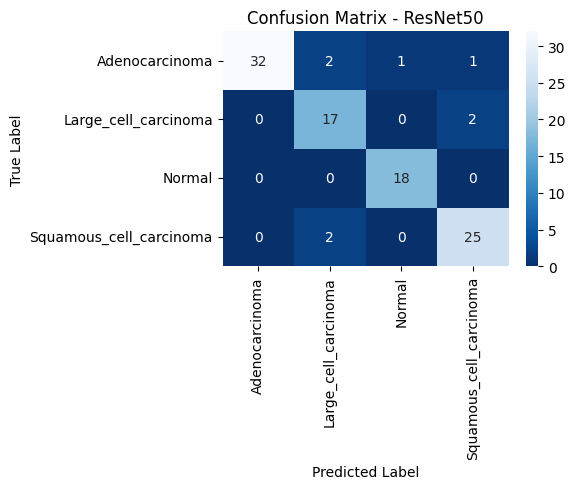

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

config = {
    'model_name': 'ResNet50',
    'lr': 0.0001,
    'batch_size': 16,
    'dropout_rate': 0.3,
    'dense_units': 1024,
    'optimizer': 'adam',
    'trainable_layers': 'last_30'
}


BaseModelClass = tf.keras.applications.ResNet50
base_model = BaseModelClass(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


for layer in base_model.layers[:-30]:
    layer.trainable = False


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(config['dense_units'], activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=config['dropout_rate'])(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)


optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    verbose=1,
    batch_size=config['batch_size'],
    callbacks=[]
)
print(f"Training time: {time.time() - start_time:.2f} seconds")


y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_test, y_pred_test, target_names=labels))

cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
